In [77]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

# Machine Learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           balanced_accuracy_score, f1_score, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

# Advanced ML libraries
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not available. Install with: pip install lightgbm")

# Explainability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available. Install with: pip install shap")

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"LightGBM available: {LIGHTGBM_AVAILABLE}")
print(f"SHAP available: {SHAP_AVAILABLE}")


Libraries imported successfully!
XGBoost available: True
LightGBM available: True
SHAP available: True


In [78]:
# Load preprocessed datasets
print("LOADING PREPROCESSED DATA")

try:
    X_train = pd.read_csv('X_train_scaled.csv')
    X_val = pd.read_csv('X_val_scaled.csv')
    X_test = pd.read_csv('X_test_scaled.csv')

     #  Save target variables
    y_train =pd.read_csv('y_train.csv')
    y_val = pd.read_csv('y_val.csv')
    y_test = pd.read_csv('y_test.csv')

    scaler = joblib.load('scaler.pkl')
    selected_features = joblib.load('selected_features.pkl')
    
    print("...Preprocessed data loaded successfully!!....")
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")
    
    # Display class distribution
    print("\nClass distribution:")
    print("Training set:")
    print(y_train.value_counts().sort_index())
    print("\nValidation set:")
    print(y_val.value_counts().sort_index())
    print("\nTest set:")
    print(y_test.value_counts().sort_index())
    
    # Display selected features
    print(f"\nSelected features ({len(selected_features)}):")
    for i, feature in enumerate(selected_features, 1):
        print(f"{i:2d}. {feature}")
        
except FileNotFoundError as e:
    print(f"Error loading preprocessed data: {e}")
    print("Please run the preprocessing notebook first to generate the required files.")
    print("Required files: X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv")
    print("                y_train.csv, y_val.csv, y_test.csv")
    print("                scaler.pkl, selected_features.pkl")

LOADING PREPROCESSED DATA
...Preprocessed data loaded successfully!!....
Training set: (368, 21)
Validation set: (123, 21)
Test set: (123, 21)

Class distribution:
Training set:
Loan_Status
0              115
1              253
Name: count, dtype: int64

Validation set:
Loan_Status
0              39
1              84
Name: count, dtype: int64

Test set:
Loan_Status
0              38
1              85
Name: count, dtype: int64

Selected features (22):
 1. Loan_ID
 2. Gender
 3. Married
 4. Dependents
 5. Education
 6. Self_Employed
 7. ApplicantIncome
 8. CoapplicantIncome
 9. LoanAmount
10. Loan_Amount_Term
11. Credit_History
12. Property_Area
13. ApplicantIncome_log
14. CoapplicantIncome_log
15. LoanAmount_log
16. income_to_loan_ratio
17. total_income
18. loan_term_years
19. emi
20. balance_income
21. loan_to_income_ratio
22. applicant_income_share


### Baseline Model - Logistic Regression 

In [79]:


print("BASELINE LOGISTIC REGRESSION MODEL")
print("EDA recommendation: Fast, interpretable baseline with coefficients for feature effect direction")


# Create and train baseline model 
baseline_model = LogisticRegression(
    random_state=234,
    max_iter=1000,
    class_weight='balanced'  # Handle class imbalance as recommended by EDA
)

# --- Train model ---
baseline_model.fit(X_train, y_train)

# --- Make predictions ---
y_train_pred = baseline_model.predict(X_train)
y_val_pred = baseline_model.predict(X_val)
y_test_pred = baseline_model.predict(X_test)

# --- Calculate performance metrics ---
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
val_balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred, average='macro')
val_f1 = f1_score(y_val, y_val_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

# --- Display baseline results ---
print("\nBaseline Model Performance:")
print(f"Training - Accuracy: {train_accuracy:.3f}, Balanced Acc: {train_balanced_acc:.3f}, Macro F1: {train_f1:.3f}")
print(f"Validation - Accuracy: {val_accuracy:.3f}, Balanced Acc: {val_balanced_acc:.3f}, Macro F1: {val_f1:.3f}")
print(f"Test - Accuracy: {test_accuracy:.3f}, Balanced Acc: {test_balanced_acc:.3f}, Macro F1: {test_f1:.3f}")

# --- Feature coefficient analysis (interpretability) ---
print("\nFeature Coefficients (Top 10):")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': baseline_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['coefficient']:.3f}")

# --- Store baseline results ---
baseline_results = {
    'model': 'Logistic Regression',
    'train_accuracy': train_accuracy,
    'val_accuracy': val_accuracy,
    'test_accuracy': test_accuracy,
    'train_balanced_acc': train_balanced_acc,
    'val_balanced_acc': val_balanced_acc,
    'test_balanced_acc': test_balanced_acc,
    'train_f1': train_f1,
    'val_f1': val_f1,
    'test_f1': test_f1
}

print("\n.... Baseline model completed!")


BASELINE LOGISTIC REGRESSION MODEL
EDA recommendation: Fast, interpretable baseline with coefficients for feature effect direction

Baseline Model Performance:
Training - Accuracy: 0.584, Balanced Acc: 0.581, Macro F1: 0.562
Validation - Accuracy: 0.496, Balanced Acc: 0.500, Macro F1: 0.481
Test - Accuracy: 0.585, Balanced Acc: 0.584, Macro F1: 0.563

Feature Coefficients (Top 10):
 1. applicant_income_share: -0.624
 2. balance_income: 0.601
 3. CoapplicantIncome: -0.595
 4. ApplicantIncome_log: 0.556
 5. total_income: -0.492
 6. LoanAmount_log: -0.447
 7. Education: -0.303
 8. CoapplicantIncome_log: 0.271
 9. Property_Area: 0.190
10. LoanAmount: 0.168

.... Baseline model completed!


In [80]:
# print("=== X_train Info Check ===")
# print(X_train.shape)
# print(pd.DataFrame(X_train).isnull().sum().sum(), "missing values in X_train")

# print("Data type:", type(X_train))


RANDOM FOREST CLASSIFIER
EDA recommendation: Robust, captures interactions, insensitive to scaling and moderate outliers

Random Forest Performance:
Training   - Accuracy: 1.000, Balanced Acc: 1.000, Macro F1: 1.000
Validation - Accuracy: 0.569, Balanced Acc: 0.451, Macro F1: 0.435
Test       - Accuracy: 0.691, Balanced Acc: 0.580, Macro F1: 0.581

Feature Importance (Top 10):
 1. total_income: 0.096
 2. ApplicantIncome: 0.092
 3. income_to_loan_ratio: 0.089
 4. ApplicantIncome_log: 0.088
 5. balance_income: 0.081
 6. loan_to_income_ratio: 0.079
 7. LoanAmount_log: 0.070
 8. emi: 0.066
 9. LoanAmount: 0.064
10. applicant_income_share: 0.063


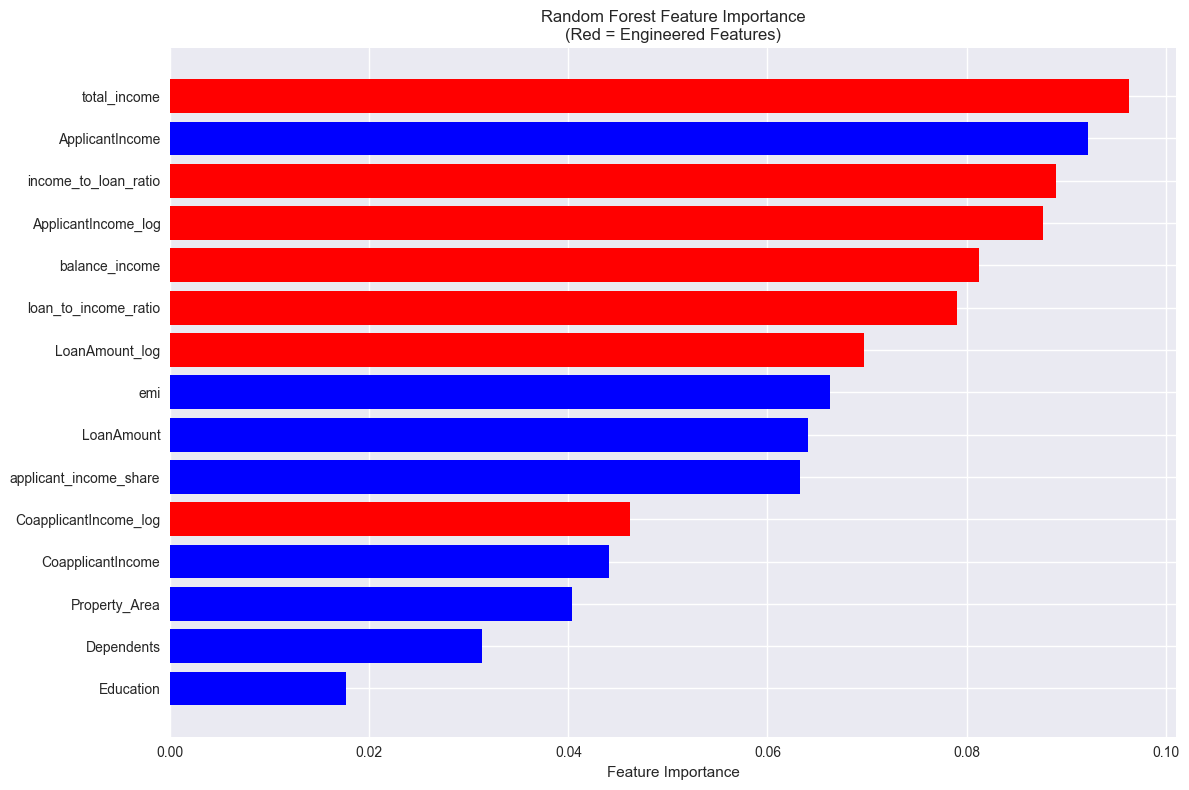

....Random Forest model completed...!


In [81]:
# --- RANDOM FOREST CLASSIFIER ---
print("RANDOM FOREST CLASSIFIER")
print("EDA recommendation: Robust, captures interactions, insensitive to scaling and moderate outliers")

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

# Create Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',  # handle class imbalance
    n_jobs=-1  # use all CPU cores
)

# --- Train the model ---
rf_model.fit(X_train, y_train)

# --- Make predictions ---
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

# --- Evaluate performance ---
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

train_balanced_acc_rf = balanced_accuracy_score(y_train, y_train_pred_rf)
val_balanced_acc_rf = balanced_accuracy_score(y_val, y_val_pred_rf)
test_balanced_acc_rf = balanced_accuracy_score(y_test, y_test_pred_rf)

train_f1_rf = f1_score(y_train, y_train_pred_rf, average='macro')
val_f1_rf = f1_score(y_val, y_val_pred_rf, average='macro')
test_f1_rf = f1_score(y_test, y_test_pred_rf, average='macro')

# --- Display results ---
print("\nRandom Forest Performance:")
print(f"Training   - Accuracy: {train_accuracy_rf:.3f}, Balanced Acc: {train_balanced_acc_rf:.3f}, Macro F1: {train_f1_rf:.3f}")
print(f"Validation - Accuracy: {val_accuracy_rf:.3f}, Balanced Acc: {val_balanced_acc_rf:.3f}, Macro F1: {val_f1_rf:.3f}")
print(f"Test       - Accuracy: {test_accuracy_rf:.3f}, Balanced Acc: {test_balanced_acc_rf:.3f}, Macro F1: {test_f1_rf:.3f}")

# --- Feature Importance ---
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Top 10):")
for i, (_, row) in enumerate(feature_importance_rf.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['importance']:.3f}")

# --- Visualize Feature Importance ---
plt.figure(figsize=(12, 8))
top_features_rf = feature_importance_rf.head(15)
colors = ['red' if any(keyword in f.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log'])
          else 'blue' for f in top_features_rf['feature']]

plt.barh(range(len(top_features_rf)), top_features_rf['importance'], color=colors)
plt.yticks(range(len(top_features_rf)), top_features_rf['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance\n(Red = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- Store Random Forest Results ---
rf_results = {
    'model': 'Random Forest',
    'train_accuracy': train_accuracy_rf,
    'val_accuracy': val_accuracy_rf,
    'test_accuracy': test_accuracy_rf,
    'train_balanced_acc': train_balanced_acc_rf,
    'val_balanced_acc': val_balanced_acc_rf,
    'test_balanced_acc': test_balanced_acc_rf,
    'train_f1': train_f1_rf,
    'val_f1': val_f1_rf,
    'test_f1': test_f1_rf
}

print("....Random Forest model completed...!")


### XGBoost Classifier

In [82]:
# --- LABEL ENCODING FOR XGBOOST COMPATIBILITY ---
print("LABEL ENCODING FOR XGBOOST COMPATIBILITY")
print("XGBoost requires class labels to start from 0 (e.g., 0/1 instead of Yes/No or 3/9)")


# Encode target variables
label_encoder = LabelEncoder()

# Combine all target splits to ensure consistent encoding
all_y = pd.concat([y_train, y_val, y_test], ignore_index=True)
label_encoder.fit(all_y)

# Apply encoding to each target split
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(f"Original classes: {list(label_encoder.classes_)}")
print(f"Encoded mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Display encoded class distribution
def show_class_distribution(encoded, name):
    unique, counts = np.unique(encoded, return_counts=True)
    print(f"{name} class distribution:")
    for cls, count in zip(unique, counts):
        print(f"  Class {cls}: {count} samples")
    print()

show_class_distribution(y_train_encoded, "Training")
show_class_distribution(y_val_encoded, "Validation")
show_class_distribution(y_test_encoded, "Test")

print("Label encoding completed!\n")

# --- XGBOOST CLASSIFIER ---
print("XGBOOST CLASSIFIER")
print("EDA recommendation: Strong gradient boosting method, handles mixed feature types, imbalance, and non-linear patterns")


# Create the model
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='binary:logistic',   # for binary classification
    eval_metric='logloss',
    scale_pos_weight=1  # can tune for imbalance
)

# --- Train model ---
xgb_model.fit(X_train, y_train_encoded,
              eval_set=[(X_val, y_val_encoded)],
              verbose=False)

# --- Predictions ---
y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb = xgb_model.predict(X_val)
y_test_pred_xgb = xgb_model.predict(X_test)

# --- Evaluation metrics ---
train_acc_xgb = accuracy_score(y_train_encoded, y_train_pred_xgb)
val_acc_xgb = accuracy_score(y_val_encoded, y_val_pred_xgb)
test_acc_xgb = accuracy_score(y_test_encoded, y_test_pred_xgb)

train_bal_xgb = balanced_accuracy_score(y_train_encoded, y_train_pred_xgb)
val_bal_xgb = balanced_accuracy_score(y_val_encoded, y_val_pred_xgb)
test_bal_xgb = balanced_accuracy_score(y_test_encoded, y_test_pred_xgb)

train_f1_xgb = f1_score(y_train_encoded, y_train_pred_xgb, average='macro')
val_f1_xgb = f1_score(y_val_encoded, y_val_pred_xgb, average='macro')
test_f1_xgb = f1_score(y_test_encoded, y_test_pred_xgb, average='macro')

print("\nXGBoost Performance:")
print(f"Training   - Accuracy: {train_acc_xgb:.3f}, Balanced Acc: {train_bal_xgb:.3f}, Macro F1: {train_f1_xgb:.3f}")
print(f"Validation - Accuracy: {val_acc_xgb:.3f}, Balanced Acc: {val_bal_xgb:.3f}, Macro F1: {val_f1_xgb:.3f}")
print(f"Test       - Accuracy: {test_acc_xgb:.3f}, Balanced Acc: {test_bal_xgb:.3f}, Macro F1: {test_f1_xgb:.3f}")

# --- Feature Importance ---
importances = xgb_model.feature_importances_
feature_importance_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Important Features:")
for i, row in enumerate(feature_importance_xgb.head(10).itertuples(), 1):
    print(f"{i:2d}. {row.Feature}: {row.Importance:.3f}")

# # --- Plot Feature Importance ---
# plt.figure(figsize=(12, 8))
# top_features_xgb = feature_importance_xgb.head(15)
# plt.barh(top_features_xgb['Feature'], top_features_xgb['Importance'], color='green')
# plt.gca().invert_yaxis()
# plt.xlabel('Importance')
# plt.title('XGBoost Feature Importance')
# plt.tight_layout()
# plt.show()

# --- Store results ---
xgb_results = {
    'model': 'XGBoost',
    'train_accuracy': train_acc_xgb,
    'val_accuracy': val_acc_xgb,
    'test_accuracy': test_acc_xgb,
    'train_balanced_acc': train_bal_xgb,
    'val_balanced_acc': val_bal_xgb,
    'test_balanced_acc': test_bal_xgb,
    'train_f1': train_f1_xgb,
    'val_f1': val_f1_xgb,
    'test_f1': test_f1_xgb
}

print("....XGBoost model completed successfully!... ")


LABEL ENCODING FOR XGBOOST COMPATIBILITY
XGBoost requires class labels to start from 0 (e.g., 0/1 instead of Yes/No or 3/9)
Original classes: [np.int64(0), np.int64(1)]
Encoded mapping: {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
Training class distribution:
  Class 0: 115 samples
  Class 1: 253 samples

Validation class distribution:
  Class 0: 39 samples
  Class 1: 84 samples

Test class distribution:
  Class 0: 38 samples
  Class 1: 85 samples

Label encoding completed!

XGBOOST CLASSIFIER
EDA recommendation: Strong gradient boosting method, handles mixed feature types, imbalance, and non-linear patterns

XGBoost Performance:
Training   - Accuracy: 0.997, Balanced Acc: 0.996, Macro F1: 0.997
Validation - Accuracy: 0.593, Balanced Acc: 0.469, Macro F1: 0.449
Test       - Accuracy: 0.691, Balanced Acc: 0.595, Macro F1: 0.599

Top 10 Important Features:
 1. applicant_income_share: 0.071
 2. Education: 0.069
 3. loan_to_income_ratio: 0.067
 4. total_income: 0.066
 5. Dependents

In [83]:
# --- XGBoost Classifier for Home Loan Dataset ---
print(".....XGBOOST CLASSIFIER....")
print("EDA recommendation: Best performance for structured data, handles non-linearity and feature interactions automatically")

# --- Ensure xgboost is available ---
# try:
#     import xgboost as xgb
#     XGBOOST_AVAILABLE = True
# except ImportError:
#     XGBOOST_AVAILABLE = False
#     print(" XGBoost not installed. Please run 'pip install xgboost' to use this model.")

# from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
# import pandas as pd
# import matplotlib.pyplot as plt

if XGBOOST_AVAILABLE:
    # --- Create XGBoost model ---
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        objective='binary:logistic',
        n_jobs=-1
    )
    
    # --- Train the model (use encoded labels) ---
    xgb_model.fit(X_train, y_train_encoded)
    
    # --- Make predictions ---
    y_train_pred_xgb = xgb_model.predict(X_train)
    y_val_pred_xgb = xgb_model.predict(X_val)
    y_test_pred_xgb = xgb_model.predict(X_test)
    
    # --- Convert predictions back to original labels ---
    y_train_pred_xgb_original = label_encoder.inverse_transform(y_train_pred_xgb)
    y_val_pred_xgb_original = label_encoder.inverse_transform(y_val_pred_xgb)
    y_test_pred_xgb_original = label_encoder.inverse_transform(y_test_pred_xgb)
    
    # --- Evaluate using original labels ---
    train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb_original)
    val_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb_original)
    test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb_original)
    
    train_balanced_acc_xgb = balanced_accuracy_score(y_train, y_train_pred_xgb_original)
    val_balanced_acc_xgb = balanced_accuracy_score(y_val, y_val_pred_xgb_original)
    test_balanced_acc_xgb = balanced_accuracy_score(y_test, y_test_pred_xgb_original)
    
    train_f1_xgb = f1_score(y_train, y_train_pred_xgb_original, average='macro')
    val_f1_xgb = f1_score(y_val, y_val_pred_xgb_original, average='macro')
    test_f1_xgb = f1_score(y_test, y_test_pred_xgb_original, average='macro')
    
    # --- Print performance summary ---
    print("\nXGBoost Performance Summary:")
    print(f"Training   - Accuracy: {train_accuracy_xgb:.3f}, Balanced Acc: {train_balanced_acc_xgb:.3f}, Macro F1: {train_f1_xgb:.3f}")
    print(f"Validation - Accuracy: {val_accuracy_xgb:.3f}, Balanced Acc: {val_balanced_acc_xgb:.3f}, Macro F1: {val_f1_xgb:.3f}")
    print(f"Test       - Accuracy: {test_accuracy_xgb:.3f}, Balanced Acc: {test_balanced_acc_xgb:.3f}, Macro F1: {test_f1_xgb:.3f}")
    
    # --- Feature Importance ---
    print(f"\nFeature Importance (Top 10):")
    feature_importance_xgb = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': xgb_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    for i, (_, row) in enumerate(feature_importance_xgb.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['Feature']}: {row['Importance']:.3f}")
    
    # --- Plot Top Features ---
    # plt.figure(figsize=(12, 8))
    # top_features = feature_importance_xgb.head(15)
    # plt.barh(top_features['Feature'], top_features['Importance'], color='green')
    # plt.gca().invert_yaxis()
    # plt.xlabel("Feature Importance")
    # plt.title("XGBoost Feature Importance (Top 15)")
    # plt.tight_layout()
    # plt.show()
    
    # --- Store results ---
    xgb_results = {
        'model': 'XGBoost',
        'train_accuracy': train_accuracy_xgb,
        'val_accuracy': val_accuracy_xgb,
        'test_accuracy': test_accuracy_xgb,
        'train_balanced_acc': train_balanced_acc_xgb,
        'val_balanced_acc': val_balanced_acc_xgb,
        'test_balanced_acc': test_balanced_acc_xgb,
        'train_f1': train_f1_xgb,
        'val_f1': val_f1_xgb,
        'test_f1': test_f1_xgb
    }
    
    print("\n XGBoost model completed successfully!")

else:
    print(" XGBoost not available — skipping XGBoost training.")
    xgb_results = None


.....XGBOOST CLASSIFIER....
EDA recommendation: Best performance for structured data, handles non-linearity and feature interactions automatically

XGBoost Performance Summary:
Training   - Accuracy: 0.973, Balanced Acc: 0.957, Macro F1: 0.968
Validation - Accuracy: 0.610, Balanced Acc: 0.481, Macro F1: 0.459
Test       - Accuracy: 0.707, Balanced Acc: 0.606, Macro F1: 0.612

Feature Importance (Top 10):
 1. applicant_income_share: 0.070
 2. Education: 0.067
 3. Property_Area: 0.066
 4. loan_to_income_ratio: 0.064
 5. total_income: 0.064
 6. Dependents: 0.062
 7. balance_income: 0.057
 8. ApplicantIncome_log: 0.056
 9. ApplicantIncome: 0.056
10. income_to_loan_ratio: 0.055

 XGBoost model completed successfully!


MODEL COMPARISON AND EVALUATION

Model Performance Comparison:
Model           Train Acc  Val Acc    Test Acc   Val F1     Test F1   
Logistic Regression 0.584      0.496      0.585      0.481      0.563     
Random Forest   1.000      0.569      0.691      0.435      0.581     
XGBoost         0.973      0.610      0.707      0.459      0.612     

 Best Model: Logistic Regression (Validation F1: 0.481)


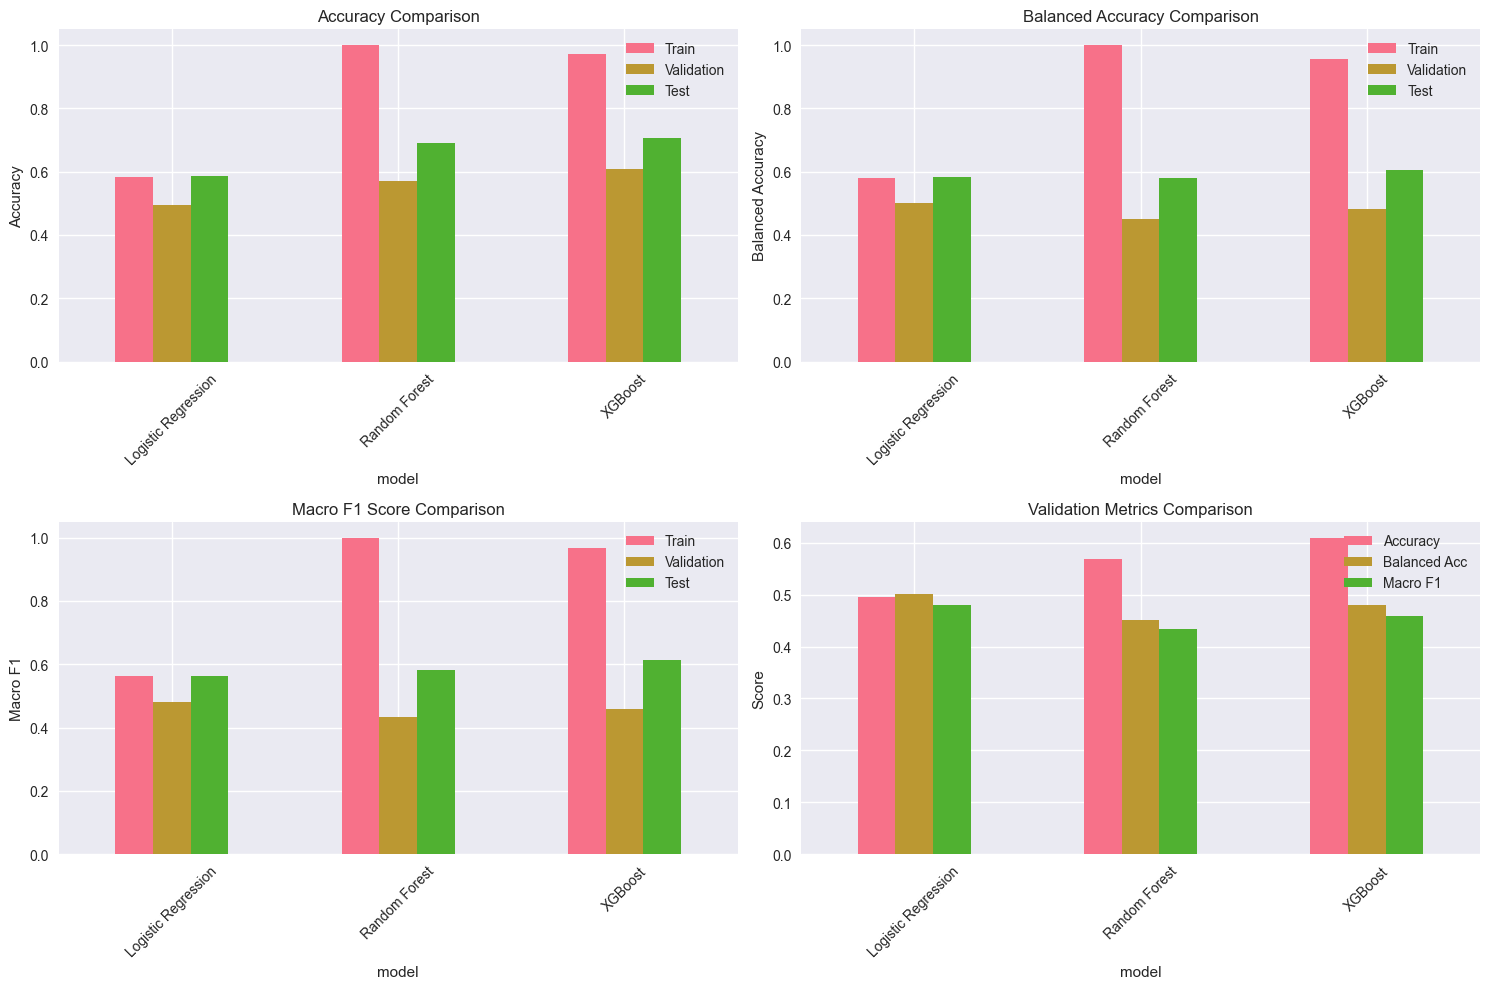

...Model comparison completed successfully!


In [84]:
print("MODEL COMPARISON AND EVALUATION")


# --- Collect all available model results ---
all_results = []

# Add baseline (e.g., Logistic Regression)
if 'baseline_results' in locals():
    all_results.append(baseline_results)

# Add Random Forest
if 'rf_results' in locals():
    all_results.append(rf_results)

# Add XGBoost if available
if 'xgb_results' in locals() and xgb_results is not None:
    all_results.append(xgb_results)

# Safety check
if not all_results:
    raise ValueError("No model results found. Please ensure models were trained and results stored properly.")

# --- Create comparison DataFrame ---
comparison_df = pd.DataFrame(all_results).set_index('model')

print("\nModel Performance Comparison:")

print(f"{'Model':<15} {'Train Acc':<10} {'Val Acc':<10} {'Test Acc':<10} {'Val F1':<10} {'Test F1':<10}")

for _, row in comparison_df.iterrows():
    print(f"{row.name:<15} {row['train_accuracy']:<10.3f} {row['val_accuracy']:<10.3f} "
          f"{row['test_accuracy']:<10.3f} {row['val_f1']:<10.3f} {row['test_f1']:<10.3f}")

# --- Identify best model based on validation F1 score ---
best_model_name = comparison_df['val_f1'].idxmax()
best_model_score = comparison_df.loc[best_model_name, 'val_f1']
print(f"\n Best Model: {best_model_name} (Validation F1: {best_model_score:.3f})")

# --- Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy comparison
comparison_df[['train_accuracy', 'val_accuracy', 'test_accuracy']].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend(['Train', 'Validation', 'Test'])
axes[0,0].tick_params(axis='x', rotation=45)

# Balanced Accuracy comparison
comparison_df[['train_balanced_acc', 'val_balanced_acc', 'test_balanced_acc']].plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Balanced Accuracy Comparison')
axes[0,1].set_ylabel('Balanced Accuracy')
axes[0,1].legend(['Train', 'Validation', 'Test'])
axes[0,1].tick_params(axis='x', rotation=45)

# F1 Score comparison
comparison_df[['train_f1', 'val_f1', 'test_f1']].plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Macro F1 Score Comparison')
axes[1,0].set_ylabel('Macro F1')
axes[1,0].legend(['Train', 'Validation', 'Test'])
axes[1,0].tick_params(axis='x', rotation=45)

# Validation metrics only
validation_metrics = comparison_df[['val_accuracy', 'val_balanced_acc', 'val_f1']]
validation_metrics.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Validation Metrics Comparison')
axes[1,1].set_ylabel('Score')
axes[1,1].legend(['Accuracy', 'Balanced Acc', 'Macro F1'])
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("...Model comparison completed successfully!")


### Detailed Evaluation of Best Model

DETAILED EVALUATION OF BEST MODEL
 Best Model Selected: Logistic Regression
Validation Macro F1 Score: 0.481

 Detailed Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.39      0.58      0.46        38
           1       0.76      0.59      0.66        85

    accuracy                           0.59       123
   macro avg       0.57      0.58      0.56       123
weighted avg       0.64      0.59      0.60       123


 Confusion Matrix for Logistic Regression:
[[22 16]
 [35 50]]


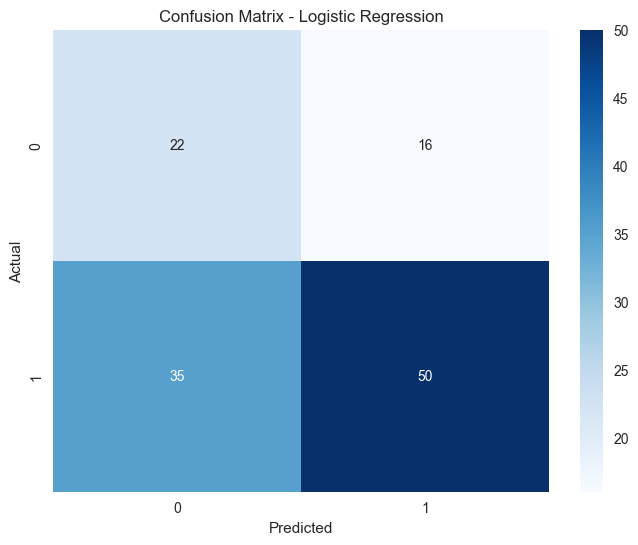


 Per-Class Performance for Logistic Regression:
Class 0: 0.579 accuracy (38 samples)
Class 1: 0.588 accuracy (85 samples)

 Detailed evaluation completed successfully!


In [85]:
print("DETAILED EVALUATION OF BEST MODEL")


# --- Identify and retrieve the best model ---
if best_model_name == 'Logistic Regression':
    best_model = baseline_model
    y_test_pred_best = y_test_pred
elif best_model_name == 'Random Forest':
    best_model = rf_model
    y_test_pred_best = y_test_pred_rf
elif best_model_name == 'XGBoost':
    best_model = xgb_model
    y_test_pred_best = y_test_pred_xgb_original if 'y_test_pred_xgb_original' in locals() else y_test_pred_xgb
else:
    raise ValueError(f"Unknown best model name: {best_model_name}")

print(f" Best Model Selected: {best_model_name}")
print(f"Validation Macro F1 Score: {best_model_score:.3f}")


# --- Ensure y_test is a Series ---
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.squeeze()  # Convert single-column DataFrame to Series

# --- Detailed Classification Report ---
print(f"\n Detailed Classification Report for {best_model_name}:")

print(classification_report(y_test, y_test_pred_best))

# --- Confusion Matrix ---
print(f"\n Confusion Matrix for {best_model_name}:")
cm = confusion_matrix(y_test, y_test_pred_best)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y_test.unique()),
            yticklabels=sorted(y_test.unique()))
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- Per-class Accuracy ---
print(f"\n Per-Class Performance for {best_model_name}:")
unique_classes = sorted(y_test.unique())
for class_label in unique_classes:
    class_mask = (y_test == class_label)
    if class_mask.sum() > 0:
        class_acc = accuracy_score(y_test[class_mask], y_test_pred_best[class_mask])
        print(f"Class {class_label}: {class_acc:.3f} accuracy ({class_mask.sum()} samples)")

print("\n Detailed evaluation completed successfully!")


In [86]:
# # # Detailed evaluation of best model
# # print ("Detailed Evaluation Of Best Model")

# # geting the best model 

# print("DETAILED EVALUATION OF BEST MODEL")


# # --- Identify and retrieve the best model ---
# if best_model_name == 'Logistic Regression':
#     best_model = baseline_model
#     y_test_pred_best = y_test_pred
# elif best_model_name == 'Random Forest':
#     best_model = rf_model
#     y_test_pred_best = y_test_pred_rf
# elif best_model_name == 'XGBoost':
#     best_model = xgb_model
#     y_test_pred_best = y_test_pred_xgb_original if 'y_test_pred_xgb_original' in locals() else y_test_pred_xgb
# else:
#     raise ValueError(f"Unknown best model name: {best_model_name}")

# print(f" Best Model Selected: {best_model_name}")
# print(f"Validation Macro F1 Score: {best_model_score:.3f}")


# # --- Detailed Classification Report ---
# print(f"\n Detailed Classification Report for {best_model_name}:")

# print(classification_report(y_test, y_test_pred_best))

# # --- Confusion Matrix ---
# print(f"\n Confusion Matrix for {best_model_name}:")
# cm = confusion_matrix(y_test, y_test_pred_best)
# print(cm)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=sorted(y_test.unique()),
#             yticklabels=sorted(y_test.unique()))
# plt.title(f'Confusion Matrix - {best_model_name}')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

# # --- Per-class Accuracy ---
# print(f"\nPer-Class Performance for {best_model_name}:")
# unique_classes = sorted(y_test.unique())
# for class_label in unique_classes:
#     class_mask = (y_test == class_label)
#     if class_mask.sum() > 0:  # Only evaluate if class exists
#         class_acc = accuracy_score(y_test[class_mask], y_test_pred_best[class_mask])
#         print(f"Class {class_label}: {class_acc:.3f} accuracy ({class_mask.sum()} samples)")

# print("\n Detailed evaluation completed successfully!")


### Save Best Model and Result

In [87]:
print("SAVING BEST MODEL AND RESULTS")

# Ensure results directory exists
os.makedirs("results", exist_ok=True)

# --- Save the best model ---
joblib.dump(best_model, "results/best_model.pkl")
print(f"-  Best model ({best_model_name}) saved as 'results/best_model.pkl'")

# --- Save model comparison results ---
comparison_path = "results/model_comparison_results.csv"
comparison_df.to_csv(comparison_path)
print(f"-  Model comparison results saved as '{comparison_path}'")

# --- Build detailed results dictionary ---
detailed_results = {
    "best_model": best_model_name,
    "best_model_score": float(best_model_score),
    "test_accuracy": float(comparison_df.loc[best_model_name, "test_accuracy"]),
    "test_balanced_acc": float(comparison_df.loc[best_model_name, "test_balanced_acc"]),
    "test_f1": float(comparison_df.loc[best_model_name, "test_f1"]),
    "confusion_matrix": cm.tolist() if "cm" in locals() else None,
    "feature_importance": None
}

# --- Add feature importance if applicable ---
if hasattr(best_model, "feature_importances_"):
    feature_importance_best = pd.DataFrame({
        "feature": X_train.columns,
        "importance": best_model.feature_importances_
    }).sort_values("importance", ascending=False)

    feature_importance_csv = "results/best_model_feature_importance.csv"
    feature_importance_best.to_csv(feature_importance_csv, index=False)
    print(f"-  Best model feature importance saved as '{feature_importance_csv}'")

    detailed_results["feature_importance"] = feature_importance_best.to_dict("records")

# --- Save detailed JSON results ---
json_path = "results/modeling_results.json"
with open(json_path, "w") as f:
    json.dump(detailed_results, f, indent=2)
print(f"-  Detailed results saved as '{json_path}'")

# --- Modeling Summary ---
print("\n MODELING SUMMARY")
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {comparison_df.loc[best_model_name, 'test_accuracy']:.3f}")
print(f"Test Balanced Accuracy: {comparison_df.loc[best_model_name, 'test_balanced_acc']:.3f}")
print(f"Test Macro F1: {comparison_df.loc[best_model_name, 'test_f1']:.3f}")

# --- Files created ---
print("\n FILES CREATED:")
print("- results/best_model.pkl (trained model)")
print("- results/model_comparison_results.csv (performance comparison)")
print("- results/modeling_results.json (detailed summary)")
if hasattr(best_model, "feature_importances_"):
    print("- results/best_model_feature_importance.csv (feature importance)")

print("\n Modeling phase completed successfully!")
print("... Ready for deployment and production use.")


SAVING BEST MODEL AND RESULTS
-  Best model (Logistic Regression) saved as 'results/best_model.pkl'
-  Model comparison results saved as 'results/model_comparison_results.csv'
-  Detailed results saved as 'results/modeling_results.json'

 MODELING SUMMARY
Best Model: Logistic Regression
Test Accuracy: 0.585
Test Balanced Accuracy: 0.584
Test Macro F1: 0.563

 FILES CREATED:
- results/best_model.pkl (trained model)
- results/model_comparison_results.csv (performance comparison)
- results/modeling_results.json (detailed summary)

 Modeling phase completed successfully!
... Ready for deployment and production use.
